## Imports

In [20]:
import collections
import gymnasium as gym
import itertools
import numpy as np
from numpy.typing import NDArray
import pandas as pd
import random
import time
import torch
from torch.optim.lr_scheduler import _LRScheduler
from typing import List, Tuple, Deque, Optional, Callable
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from GolfField import GolfField, Point, Ball
from GolfEnv import GolfEnv, GolfEnv8d1p
from utils import QNetwork, MinimumExponentialLR, EpsilonGreedy, ReplayBuffer, \
                  train_dqn2_agent, get_episode_len, train_dqn1_agent, train_naive_agent, \
                  train_reinforce_discrete, sample_one_episode, train_a2c_discrete, sample_one_episode_value

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def get_episode_len_fix(env, q_network, epsilon_greedy, device='cpu'):
    state, info = env.reset()
    episode_len = 0

    for t in itertools.count():
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action_dist = q_network(state_tensor).squeeze()
        action = epsilon_greedy(state)

        state, reward, done, truncated, _ = env.step(action)
        if done:
            break
        episode_len += 1

    return episode_len

## Environment

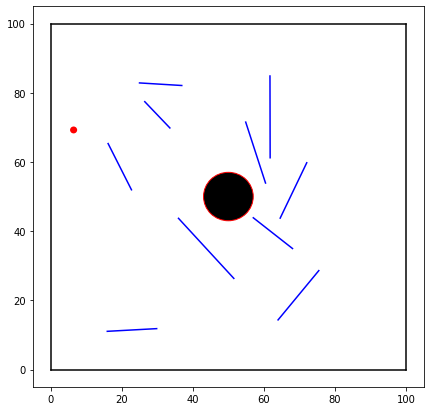

In [5]:
env = GolfEnv8d1p(0, 10, lambda old_dist, new_dist: ((new_dist < old_dist) * 2 - 1) * 100)
env.field.hole = Ball(Point(50, 50), 7)
env.field.hole_R = 7
env.reset()
env.render()

## Naive DQN

In [37]:
device = 'cpu'
NUMBER_OF_TRAININGS = 3
naive_trains_result_list = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):
    q_network = QNetwork(2, 8, nn_l1=128, nn_l2=128).to(device)
    optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()

    epsilon_greedy = EpsilonGreedy(epsilon_start=0.82, epsilon_min=0.013, epsilon_decay=0.9675, env=env, q_network=q_network)

    # Train the q-network

    episode_reward_list = train_naive_agent(env,
                                            q_network,
                                            optimizer,
                                            loss_fn,
                                            epsilon_greedy,
                                            device,
                                            lr_scheduler,
                                            num_episodes=2000,
                                            gamma=0.9)
    naive_trains_result_list[0].extend(range(len(episode_reward_list)))
    naive_trains_result_list[1].extend(episode_reward_list)
    naive_trains_result_list[2].extend([train_index for _ in episode_reward_list])

naive_trains_result_df = pd.DataFrame(np.array(naive_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
naive_trains_result_df["agent"] = "Naive"

# Save the action-value estimation function of the last train

torch.save(q_network, "naive_q_network.pth")

100%|██████████| 9/9 [00:06<00:00,  1.37it/s]


99


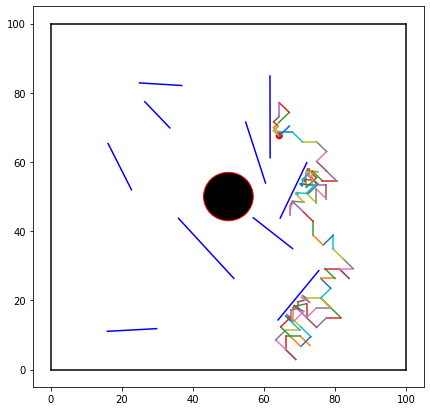

In [38]:
print(get_episode_len(env, q_network, epsilon_greedy))
env.render()

In [39]:
lens = np.array([get_episode_len_fix(env, q_network, epsilon_greedy) for i in tqdm(range(500))])
print('Mean route len:', np.mean(lens))
print('Success rate:', np.mean(lens < 99))

100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

Mean route len: 99.0
Success rate: 0.0


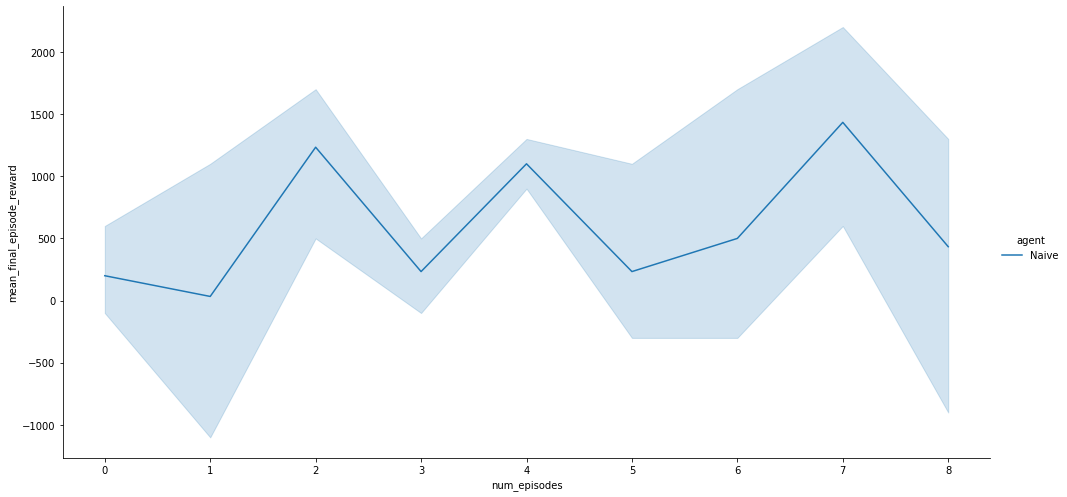

In [40]:
# g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", estimator=None, units="training_index", data=naive_trains_result_df,
#                 height=7, aspect=2, alpha=0.5);
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", hue="agent", kind="line", data=naive_trains_result_df, height=7, aspect=2)

## DQN with buffer

In [5]:
device = 'cpu'
NUMBER_OF_TRAININGS = 3
dqn1_trains_result_list = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):
    q_network = QNetwork(2, 8, nn_l1=128, nn_l2=128).to(device)
    optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()

    epsilon_greedy = EpsilonGreedy(epsilon_start=0.82, epsilon_min=0.013, epsilon_decay=0.9675, env=env, q_network=q_network)

    replay_buffer = ReplayBuffer(2000)

    # Train the q-network

    episode_reward_list = train_dqn1_agent(env,
                                           q_network,
                                           optimizer,
                                           loss_fn,
                                           epsilon_greedy,
                                           device,
                                           lr_scheduler,
                                           num_episodes=2000,
                                           gamma=0.9,
                                           batch_size=64,
                                           replay_buffer=replay_buffer)
    dqn1_trains_result_list[0].extend(range(len(episode_reward_list)))
    dqn1_trains_result_list[1].extend(episode_reward_list)
    dqn1_trains_result_list[2].extend([train_index for _ in episode_reward_list])

dqn1_trains_result_df = pd.DataFrame(np.array(dqn1_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
dqn1_trains_result_df["agent"] = "DQN 2013"

# Save the action-value estimation function

torch.save(q_network, "dqn1_q_network.pth")

100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


[600, 500, -900, 1300, -500, 500, 900, -100, 300]


100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


[-100, -100, 300, -500, -700, 100, -1900, 700, 500]


100%|██████████| 9/9 [00:09<00:00,  1.07s/it]

[900, 1100, -500, -900, 1500, 800, 400, 500, 700]


99


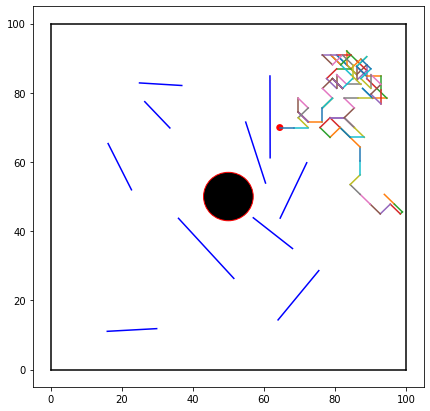

In [6]:
print(get_episode_len_fix(env, q_network, epsilon_greedy))
env.render()

In [7]:
lens = np.array([get_episode_len_fix(env, q_network, epsilon_greedy) for i in tqdm(range(500))])
print('Mean route len:', np.mean(lens))
print('Success rate:', np.mean(lens < 99))

100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

Mean route len: 69.6
Success rate: 0.4


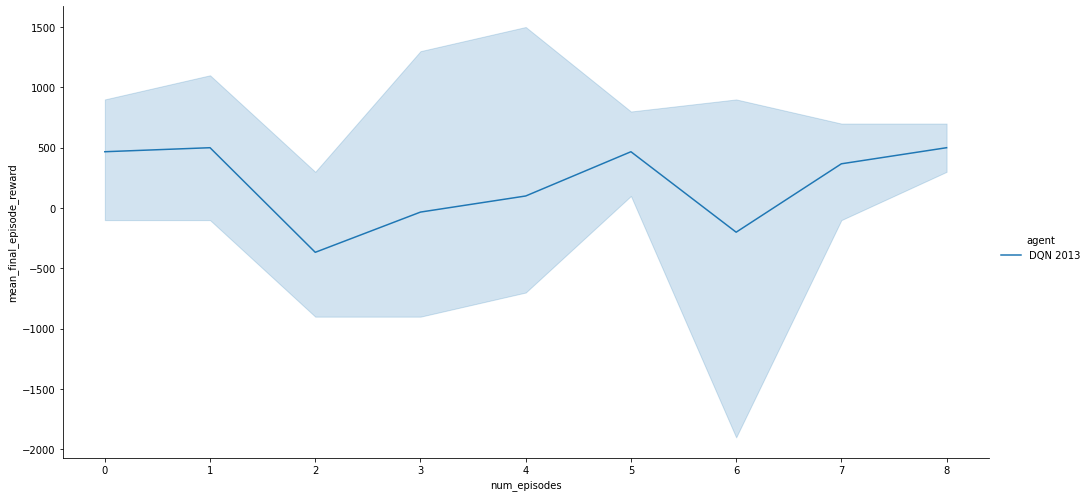

In [9]:
# g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", estimator=None, units="training_index", data=dqn1_trains_result_df,
#                 height=7, aspect=2, alpha=0.5);
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", hue="agent", kind="line", data=dqn1_trains_result_df, height=7, aspect=2)

## DQN with target network

In [11]:
device = 'cpu'
NUMBER_OF_TRAININGS = 3
dqn2_trains_result_list = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):
    state_dim = 2
    action_dim = 8
    q_network = QNetwork(state_dim, action_dim, nn_l1=128, nn_l2=128).to(device)
    target_q_network = QNetwork(state_dim, action_dim, nn_l1=128, nn_l2=128).to(device)
    target_q_network.load_state_dict(q_network.state_dict())

    optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()

    epsilon_greedy = EpsilonGreedy(epsilon_start=0.82, epsilon_min=0.013, epsilon_decay=0.9675, env=env, q_network=q_network)

    replay_buffer = ReplayBuffer(2000)

    # Train the q-network

    episode_reward_list = train_dqn2_agent(env,
                                           q_network,
                                           target_q_network,
                                           optimizer,
                                           loss_fn,
                                           epsilon_greedy,
                                           device,
                                           lr_scheduler,
                                           num_episodes=2000,
                                           gamma=0.9,
                                           batch_size=128,
                                           replay_buffer=replay_buffer,
                                           target_q_network_sync_period=30)
    dqn2_trains_result_list[0].extend(range(len(episode_reward_list)))
    dqn2_trains_result_list[1].extend(episode_reward_list)
    dqn2_trains_result_list[2].extend([train_index for _ in episode_reward_list])

dqn2_trains_result_df = pd.DataFrame(np.array(dqn2_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
dqn2_trains_result_df["agent"] = "DQN 2015"

# Save the action-value estimation function

torch.save(q_network, "dqn2_q_network.pth")

100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


72


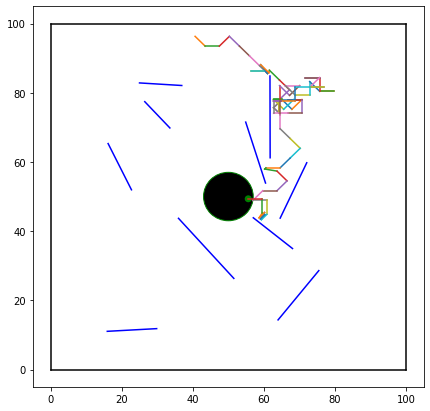

In [13]:
print(get_episode_len_fix(env, q_network, epsilon_greedy))
env.render()

In [17]:
lens = np.array([get_episode_len_fix(env, q_network, epsilon_greedy) for i in tqdm(range(500))])
print('Mean route len:', np.mean(lens))
print('Success rate:', np.mean(lens < 99))

100%|██████████| 10/10 [00:05<00:00,  1.85it/s]

Mean route len: 85.2
Success rate: 0.2


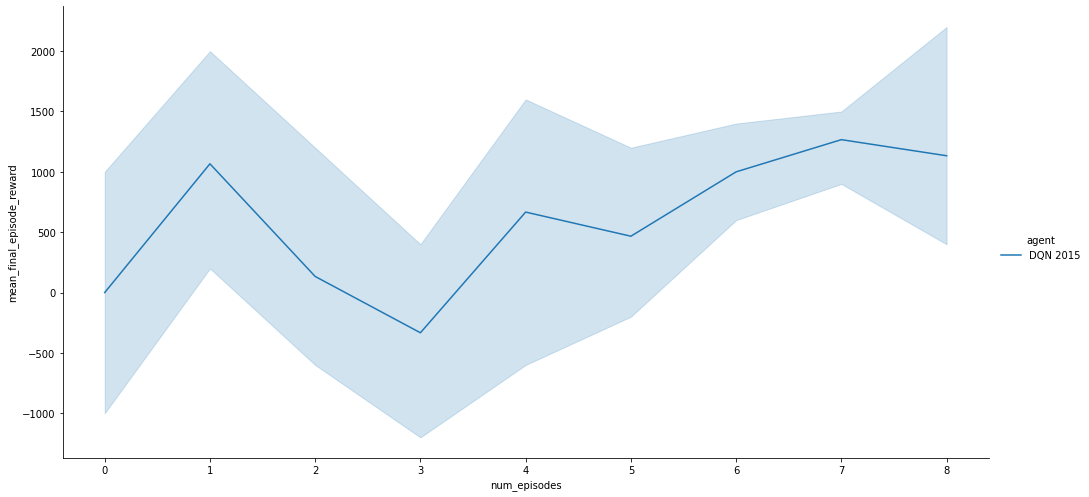

In [18]:
# g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", estimator=None, units="training_index", data=dqn2_trains_result_df,
#                 height=7, aspect=2, alpha=0.5);
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", hue="agent", kind="line", data=dqn2_trains_result_df, height=7, aspect=2)

37
99
11
99
47
99
99
99
99
13
99
99


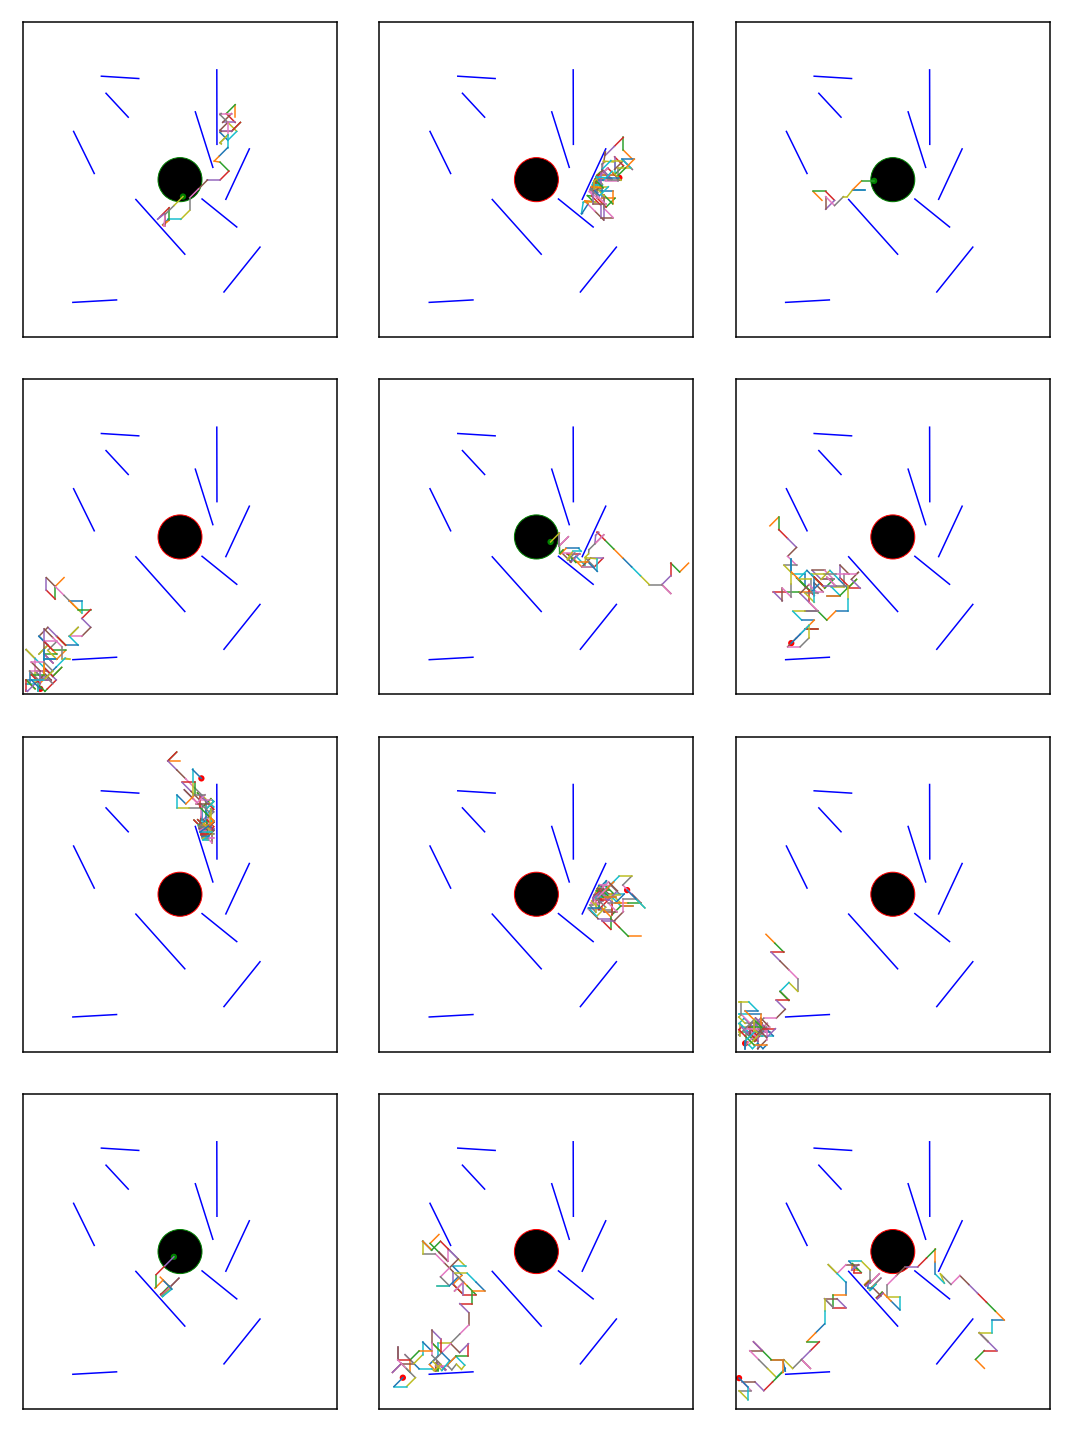

In [21]:
fig, axes = plt.subplots(4, 3, figsize=(15, 20))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ln = get_episode_len(env, q_network, epsilon_greedy)
    print(ln)

    env.render(ax)
    ax.axis('off')

plt.tight_layout()
plt.show()

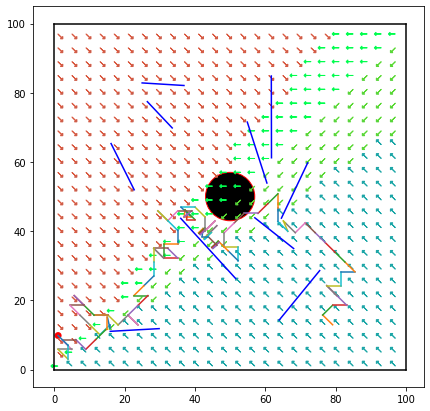

In [23]:
fig, ax = plt.subplots(figsize=(7, 7))

func_for_action = lambda x, y: (q_network(torch.tensor([x, y], dtype=torch.float32)).squeeze().argmax().item() * (360 / 8), 4)

func_for_action(40, 30)
env.render_wind(func_for_action, ax)

## REINFORCE

In [10]:
device = 'cpu'
NUMBER_OF_TRAININGS = 3
reinforce_trains_result_list = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):

    # Train the agent
    reinforce_policy_nn, episode_reward_list = train_reinforce_discrete(env=env,
                                                                        num_train_episodes=2000,
                                                                        num_test_per_episode=1,
                                                                        max_episode_duration=101,
                                                                        learning_rate=1e-6)

    reinforce_trains_result_list[0].extend(range(len(episode_reward_list)))
    reinforce_trains_result_list[1].extend(episode_reward_list)
    reinforce_trains_result_list[2].extend([train_index for _ in episode_reward_list])

reinforce_trains_result_df = pd.DataFrame(np.array(reinforce_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
reinforce_trains_result_df["agent"] = "REINFORCE"

# Save the action-value estimation function of the last train

torch.save(reinforce_policy_nn, "reinforce_policy_network.pth")

env.close()

  0%|          | 0/10 [00:00<?, ?it/s]/home/alex/ep/agents/golfRL-project/utils.py:786: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_probs = policy_nn(torch.tensor(state, dtype=torch.float32))
/home/alex/ep/agents/golfRL-project/utils.py:760: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


100


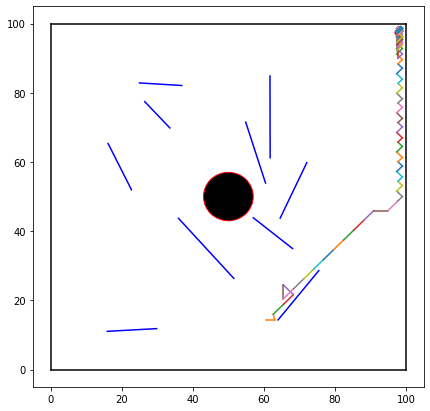

In [12]:
episode_states, episode_actions, episode_rewards, episode_log_prob_actions = sample_one_episode(env, reinforce_policy_nn, max_episode_duration=101)
print(len(episode_states))
env.render()

In [13]:
lens = np.array([len(sample_one_episode(env, reinforce_policy_nn, max_episode_duration=101)[0]) for i in tqdm(range(500))])
print('Mean route len:', np.mean(lens))
print('Success rate:', np.mean(lens < 99))

100%|██████████| 10/10 [00:13<00:00,  1.38s/it]

Mean route len: 100.0
Success rate: 0.0


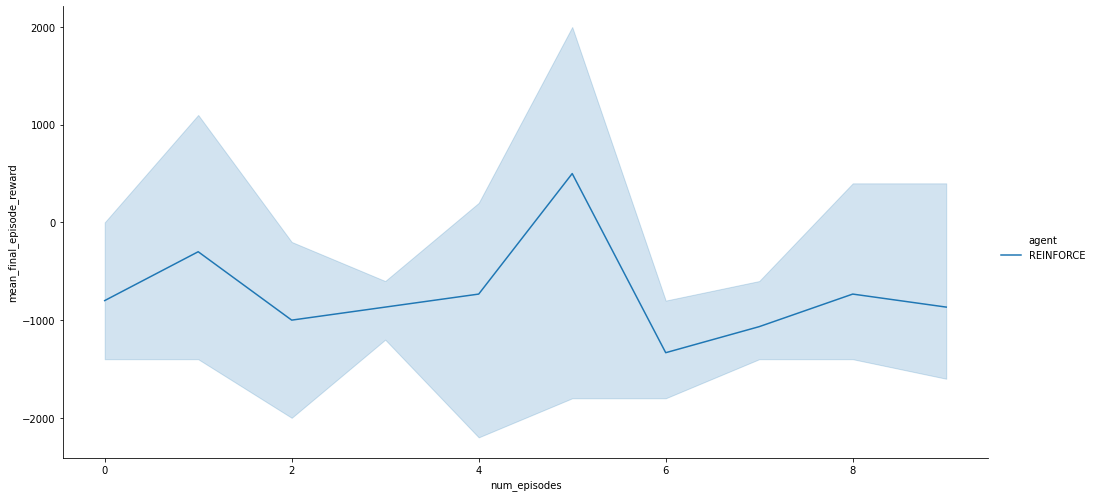

In [14]:
# g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", estimator=None, units="training_index", data=dqn2_trains_result_df,
#                 height=7, aspect=2, alpha=0.5);
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", hue="agent", kind="line", data=reinforce_trains_result_df, height=7, aspect=2)

## A2C

In [29]:
device = 'cpu'
NUMBER_OF_TRAININGS = 3
a2c_trains_result_list = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):

    # Train the agent
    a2c_policy_nn, episode_reward_list = train_a2c_discrete(env=env,
                                                            num_train_episodes=2000,
                                                            num_test_per_episode=1,
                                                            max_episode_duration=50,
                                                            learning_rate=4e-3)

    a2c_trains_result_list[0].extend(range(len(episode_reward_list)))
    a2c_trains_result_list[1].extend(episode_reward_list)
    a2c_trains_result_list[2].extend([train_index for _ in episode_reward_list])

a2c_trains_result_df = pd.DataFrame(np.array(reinforce_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
a2c_trains_result_df["agent"] = "A2C"

# Save the action-value estimation function of the last train

torch.save(reinforce_policy_nn, "a2c_policy_network.pth")

env.close()

100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


101


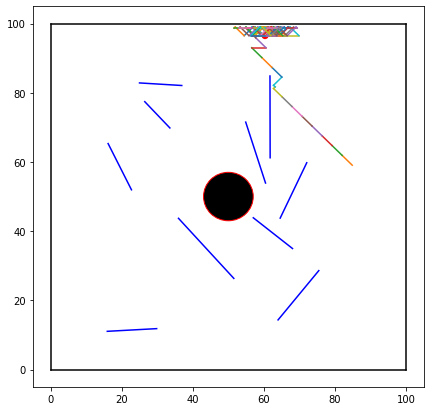

In [30]:
episode_states, _, _, _, _, _ = sample_one_episode_value(env, a2c_policy_nn, max_episode_duration=101)
print(len(episode_states))
env.render()

In [31]:
lens = np.array([len(sample_one_episode_value(env, reinforce_policy_nn, max_episode_duration=101)[0]) for i in tqdm(range(500))])
print('Mean route len:', np.mean(lens))
print('Success rate:', np.mean(lens < 99))

100%|██████████| 10/10 [00:13<00:00,  1.34s/it]

Mean route len: 101.0
Success rate: 0.0


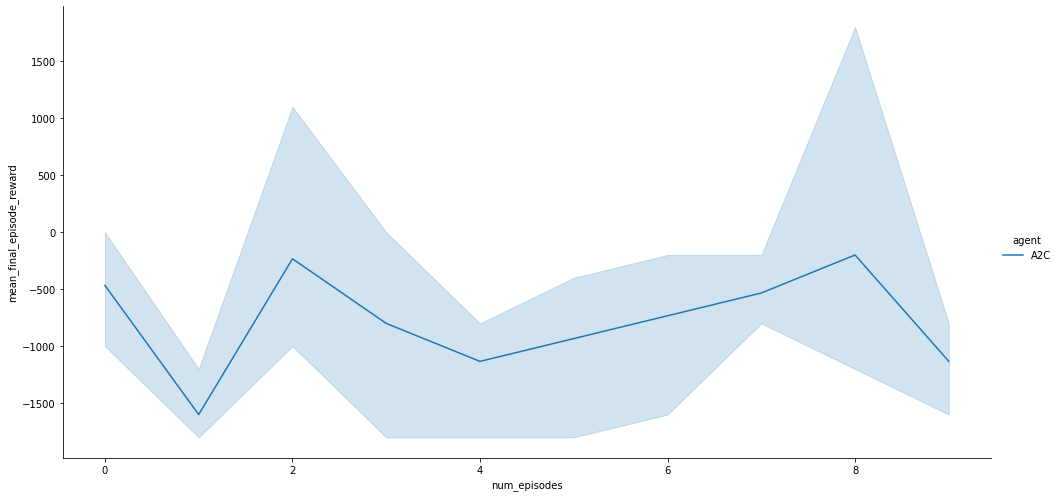

In [32]:
# g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", estimator=None, units="training_index", data=dqn2_trains_result_df,
#                 height=7, aspect=2, alpha=0.5);
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", hue="agent", kind="line", data=reinforce_trains_result_df, height=7, aspect=2)